In [1]:
split_version = 'v5'

In [2]:
import pandas as pd
import os

df0 = pd.read_csv('../data/birdclef-2024/train_metadata.csv').reset_index(drop=True)
df0['id'] = df0.index
df = df0.dropna().reset_index(drop=True)[['latitude', 'longitude', 'primary_label']]
os.makedirs('../data_processed/', exist_ok=True)


In [3]:
# from geopy.geocoders import Nominatim
# from geopy.exc import GeopyError
# from tqdm import tqdm

# geolocator = Nominatim(user_agent="geo_country_locator")
# def get_country(lat, lon):
#     try:
#         location = geolocator.reverse((lat, lon), language='en', timeout=10)
#         if location and 'country' in location.raw['address']:
#             return location.raw['address']['country']
#         else:
#             return "Unknown"
#     except GeopyError:
#         return "Error"

# tqdm.pandas()
# country_list = []
# for idx, row in tqdm(df.iterrows(), total=len(df)):
#     country = get_country(row['latitude'], row['longitude'])
#     country_list.append(country)

# df['country'] = country_list
# df.to_csv('../data_processed/points_with_countries_final.csv', index=False)

In [4]:
import pandas as pd
from scipy.stats import entropy

# Define constants for train and test target sizes
n_test_birds = 100
n_train_target_country = 500
n_test_target_country = 1000
n_unlabeled_target_country = 1200

# Load and preprocess the dataset
df = pd.read_csv('../data_processed/points_with_countries_final.csv')
df = df[~df.country.isna()]  # Remove rows with missing country data
country_counts = df['country'].value_counts()  # Get counts of samples per country

# Define a function to calculate KL divergence
def KL(country='India'):
    # Frequency distribution of primary labels for the target and non-target country
    freq_A = df[df['country'] == country]['primary_label'].value_counts(normalize=True)
    freq_B = df[df['country'] != country]['primary_label'].value_counts(normalize=True)
    
    # Ensure the frequency vectors have the same support (labels)
    all_birds = set(freq_A.index).union(set(freq_B.index))
    freq_A = freq_A.reindex(all_birds, fill_value=0)
    freq_B = freq_B.reindex(all_birds, fill_value=0)
    
    # Add a small smoothing factor to avoid zeros
    alpha = 1e-6
    freq_A = (freq_A + alpha) / (freq_A.sum() + alpha * len(all_birds))
    freq_B = (freq_B + alpha) / (freq_B.sum() + alpha * len(all_birds))
    
    # Return the KL divergence
    return entropy(freq_A, freq_B)

# Identify countries with more than 1000 samples
countries = list(country_counts[country_counts > 1000].index)
print("Countries with more than 1000 samples:", countries)

# Find the country with the maximum KL divergence
max_kl_value = -float('inf')
max_kl_country = None

for country in countries:
    kl_AB = KL(country)
    if kl_AB > max_kl_value:
        max_kl_value = kl_AB
        max_kl_country = country

print(f"The country with the maximum KL divergence is {max_kl_country} with a value of {max_kl_value}.")

Countries with more than 1000 samples: ['India', 'Spain', 'France', 'Thailand', 'China']
The country with the maximum KL divergence is India with a value of 2.3518823777473523.


In [5]:
# Create a subset of the DataFrame for the selected country
df_selected_country = df[df.country == max_kl_country]

# Filter the DataFrame to include only rows where primary_label appears at least 3 times
filtered_df = df_selected_country[df_selected_country['primary_label']
                                   .map(df_selected_country['primary_label'].value_counts()) >= 4]

# Extract the unique primary_labels from the filtered DataFrame
unique_labels = filtered_df['primary_label'].unique()

# Randomly select 100 unique primary_labels with random_state=0
selected_labels = pd.Series(unique_labels).sample(n=n_test_birds, random_state=0)
df_selected_country_and_label = df_selected_country[df_selected_country.primary_label.isin(selected_labels)]
df_selected_country_and_label = df_selected_country_and_label.sample(frac=1, random_state=0).reset_index(drop=True)

In [6]:
import pandas as pd

# Group data by primary_label
grouped = df_selected_country_and_label.groupby('primary_label')

# Initialize train and test data lists
train_data = []
test_data = []
unlabeled_data = []

# Iterate over each group to allocate samples
for label, group in grouped:
    if len(group) >= 4:
        train_samples = group.sample(n=2, random_state=0)
        train_data.append(train_samples)
        test_sample = group.drop(train_samples.index).sample(n=1, random_state=0)
        test_data.append(test_sample)
        unlabeled_sample = group.drop(train_samples.index).drop(test_sample.index).sample(n=1, random_state=0)
        unlabeled_data.append(unlabeled_sample)
    else:
        raise ValueError(f"Label '{label}' does not have enough samples (at least 3 required)")

# Concatenate the train and test data into DataFrames
df_train1 = pd.concat(train_data).reset_index(drop=True)
df_test1 = pd.concat(test_data).reset_index(drop=True)
df_unlabeled1 = pd.concat(unlabeled_data).reset_index(drop=True)

# Validation: Ensure constraints are met
assert df_train1.groupby('primary_label').size().min() == 2, "Train set doesn't have 2 samples per label"
assert df_test1.groupby('primary_label').size().min() == 1, "Test set doesn't have 1 sample per label"
assert df_unlabeled1.groupby('primary_label').size().min() == 1, "Unlabeled set doesn't have 1 sample per label"
assert len(set(df_train1['primary_label'])) == len(set(df_test1['primary_label'])) == len(set(df_unlabeled1['primary_label'])), "Mismatch in labels between train and test sets"

print(f"Train samples: {len(df_train1)}, Test samples: {len(df_test1)}, Unlabeled samples: {len(df_unlabeled1)}")

df_remaining = df_selected_country_and_label[~df_selected_country_and_label.id.isin(list(df_train1.id) + list(df_test1.id)+ list(df_unlabeled1.id))]
df_train2 = df_remaining.sample(n = n_train_target_country-2*n_test_birds, random_state=0).reset_index(drop=True)
df_remaining = df_remaining[~df_remaining.id.isin(df_train2.id)]
df_test2 = df_remaining.sample(n = n_test_target_country-n_test_birds, random_state=0).reset_index(drop=True)
df_unlabeled2 = df_remaining[~df_remaining.id.isin(df_test2.id)].reset_index(drop=True)

print(f"Train samples: {len(df_train2)}, Test samples: {len(df_test2)}, Unlabeled samples: {len(df_unlabeled2)}")

Train samples: 200, Test samples: 100, Unlabeled samples: 100
Train samples: 300, Test samples: 900, Unlabeled samples: 773


In [7]:
df_selected_country_not_label = df_selected_country[~df_selected_country.primary_label.isin(selected_labels)].sample(frac=1, random_state=0).reset_index(drop=True)

# Split into 750 samples and the remaining samples
df_unlabeled3 = df_selected_country_not_label.head(n_unlabeled_target_country-len(df_unlabeled1)-len(df_unlabeled2))
df_train3 = df_selected_country_not_label.tail(len(df_selected_country_not_label) - (n_unlabeled_target_country-len(df_unlabeled1)-len(df_unlabeled2)))

# Check the sizes of the two datasets
print(f"Train samples: {len(df_train3)}, Unlabeled samples: {len(df_unlabeled3)}")

other_countries_df = df[df.country != max_kl_country]
df_train4 = other_countries_df[other_countries_df.primary_label.isin(selected_labels)].sample(frac=0.1, random_state=0).reset_index(drop=True)
df_train5 = other_countries_df[~other_countries_df.primary_label.isin(selected_labels)].reset_index(drop=True)
print(f"Train samples: {len(df_train3)}, Train samples: {len(df_train4)}")

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5]).sample(frac=1, random_state=0).reset_index(drop=True)
df_test = pd.concat([df_test1, df_test2]).sample(frac=1, random_state=0).reset_index(drop=True)
df_unlabeled = pd.concat([df_unlabeled1, df_unlabeled2, df_unlabeled3]).sample(frac=1, random_state=0).reset_index(drop=True)

print(f"Train samples: {len(df_train)}, Test samples: {len(df_test)}, Unlabeled samples: {len(df_unlabeled)}")

Train samples: 1319, Unlabeled samples: 327
Train samples: 1319, Train samples: 896
Train samples: 13812, Test samples: 1000, Unlabeled samples: 1200


In [8]:
df_train_id = list(df_train.id)
df_test_id = list(df_test.id)
df_unlabeled_id = list(df_unlabeled.id)

# Assign set labels to the original DataFrame
def assign_set(row):
    if row['id'] in df_train_id:
        return 'train'
    elif row['id'] in df_test_id:
        return 'test'
    elif row['id'] in df_unlabeled_id:
        return 'unlabeled'
    else:
        return 'unknown'  # Handle unexpected cases

df0['set'] = df0.apply(assign_set, axis=1)

# Check the distribution of rows in each set
print(df0['set'].value_counts())

# Save the processed DataFrame
# df0.to_csv('../data_processed/train_metadata_sets_'+split_version+'.csv', index=False)

set
train        13812
unknown       8447
unlabeled     1200
test          1000
Name: count, dtype: int64


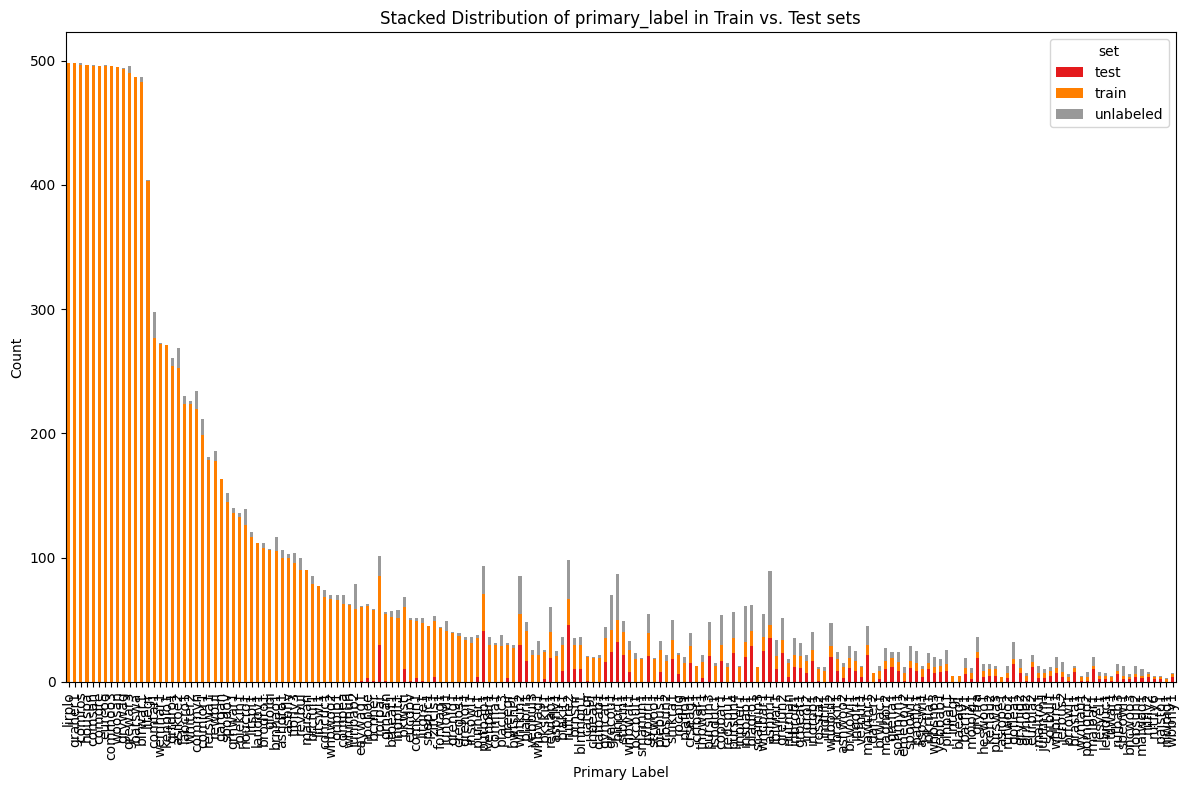

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df_train_test_0 = df0[df0.set.isin(['train', 'test', 'unlabeled'])][['primary_label', 'set']]

# Group by 'primary_label' and 'set' and count the occurrences
df_train_test = df_train_test_0.groupby(['primary_label', 'set']).size().reset_index(name='count')

# Pivot the data so we get one column for each 'set' value (train and test)
df_pivot = df_train_test.pivot(index='primary_label', columns='set', values='count').fillna(0)

# Sort the data by 'train' count to order the primary_labels by train distribution
df_pivot = df_pivot.loc[df_pivot['train'].sort_values(ascending=False).index]

# Create a stacked bar plot
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')

# Add labels and title
plt.title('Stacked Distribution of primary_label in Train vs. Test sets')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x labels if needed
plt.tight_layout()

# Show the plot
plt.show()

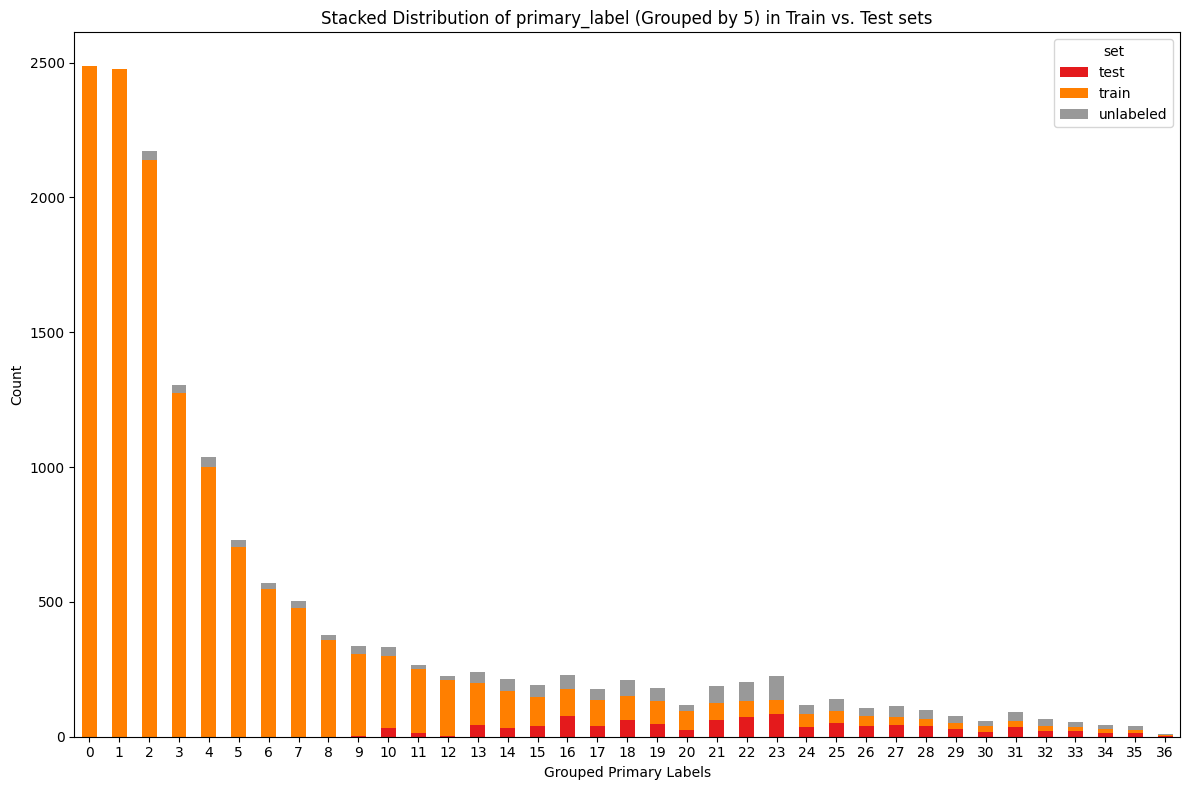

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by 'primary_label' and 'set' and count the occurrences
df_train_test = df_train_test_0.groupby(['primary_label', 'set']).size().reset_index(name='count')

# Pivot the data so we get one column for each 'set' value (train and test)
df_pivot = df_train_test.pivot(index='primary_label', columns='set', values='count').fillna(0)

# Sort the data by 'train' count to order the primary_labels by train distribution
df_pivot = df_pivot.loc[df_pivot['train'].sort_values(ascending=False).index]

# Create a new column for grouping based on row position (index) into chunks of 5
df_pivot['group'] = df_pivot.reset_index().index // 5  # Use the row index to group

# Sum the counts for each group
df_grouped = df_pivot.groupby('group').sum()

# Create a stacked bar plot for the grouped data
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')

# Add labels and title
plt.title('Stacked Distribution of primary_label (Grouped by 5) in Train vs. Test sets')
plt.xlabel('Grouped Primary Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels if needed for better readability
plt.tight_layout()

# Show the plot
plt.show()